In [1184]:
from phidl import Device, Layer, LayerSet, Port
from phidl.device_layout import DeviceReference
from phidl import quickplot as qp
from phidl import set_quickplot_options

import phidl.geometry as pg
import phidl.utilities as pu
import phidl.routing as pr
import phidl.path as pp

import numpy as np
import pickle

from dataclasses import dataclass, field, replace

import copy

from typing import Tuple, Optional, Union

import itertools
import importlib

from components import utils
importlib.reload(utils)

from components import qrcsj_device
importlib.reload(qrcsj_device)

from components import default_layerset
importlib.reload(default_layerset)
from components import frame
importlib.reload(frame)
from components import feedline
importlib.reload(feedline)
from components import spiral
importlib.reload(spiral)
from components import junction
importlib.reload(junction)
from components import resistor
importlib.reload(resistor)
from components import junction_resistor
importlib.reload(junction_resistor)
from components import ground_capacitor
importlib.reload(ground_capacitor)
from components import squid_resistor
importlib.reload(squid_resistor)
from components import junction_squid_resistor
importlib.reload(junction_squid_resistor)
from components import squid
importlib.reload(squid)

from components.qrcsj_device import QRCSJDevice
from components.default_layerset import default_ls
from components.frame import Frame, FrameParams
from components.feedline import Feedline, FeedlineParams, SquarePortParams
from components.spiral import Spiral, SpiralParams
from components.junction import JJ, JJParams
from components.resistor import Resistor, ResParams
from components.junction_resistor import JJResistor, CapaParams
from components.ground_capacitor import GroundCapa, GroundCapaParams
from components.squid_resistor import SquidResistor, SquidParams
from components.junction_squid_resistor import JJSquidResistor
from components.squid import Squid
from components.utils import WritefieldParams

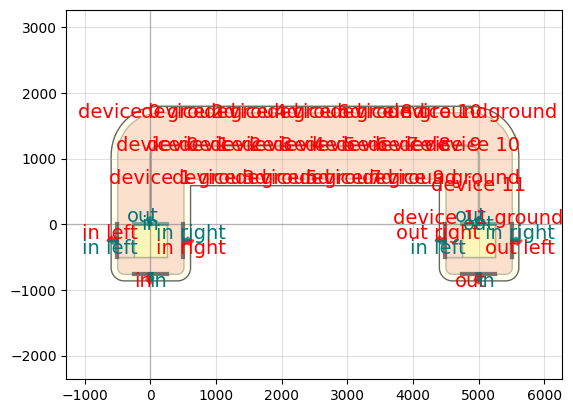

In [1185]:
feedline_bot = Feedline()

feedline_points = [(0, 0), (0, 1200), (5000, 1200), (5000, 0)]
# device_points = [(x, 1200) for x in np.linspace(start=100, stop=4900, num=9)]

device_points = [(x, 1200) for x in np.linspace(start=100, stop=4900, num=11)] + [(5000, 600)]
device_orientations = [90, -90, 90, -90, 90, -90, 90, -90, 90, -90, 90] + [0]
ground_points = [(device_point[0], device_point[1] + (505*(-1)**i)) for i, device_point in enumerate(device_points)] + [(5505, 600)]
    
#feedline_bot.generate_feedline(FeedlineParams(feedline_points=feedline_points, device_points=device_points))

feedline_bot.generate_feedline(FeedlineParams(feedline_points=feedline_points, 
                                              device_points=device_points, 
                                              device_ground_points=ground_points,
                                              device_orientations=device_orientations))
qp(feedline_bot.device)

In [1186]:
Ns = np.concatenate([np.round(np.linspace(15.1, 15.65, 11), 2), [15.9]])

Ns_multiplex = [[Ns[((i)*4)+j] for i in range(3)] for j in range(4)]
Ns_multiplex = [N for Ns in Ns_multiplex for N in Ns]


print(Ns)
print(Ns_multiplex)

[15.1  15.16 15.21 15.26 15.32 15.38 15.43 15.48 15.54 15.6  15.65 15.9 ]
[15.1, 15.32, 15.54, 15.16, 15.38, 15.6, 15.21, 15.43, 15.65, 15.26, 15.48, 15.9]


In [1187]:
Ns_multiplex[len(Ns_multiplex)//2-1:-2]

[15.6, 15.21, 15.43, 15.65, 15.26]

In [1188]:
Ns_multiplex[:len(Ns_multiplex)//2-1]

[15.1, 15.32, 15.54, 15.16, 15.38]

In [1189]:
squid_params = SquidParams()
list_capa_params = [CapaParams(length_y=20+1.9, no_resistor=True)] + [CapaParams(length_y=4-0.975-0.49)]+[CapaParams(length_y=5-1.15-0.04)]+[CapaParams(length_y=5-1.04)]+[CapaParams(length_y=5-0.95+0.075)]
writefield_params = WritefieldParams()

In [1190]:
list_res_params = []

list_res_params.append(ResParams(num_segments=2, segment_length=25)) #100kOhm

list_res_params.append(ResParams(small_resistor=True, connectors=False, num_segments=48, segment_length=6, spacing=1.5, highdose_layer=default_ls['ebeam'], ebeam_layer=default_ls['ebeam_low'], undercut_layer=default_ls['undercut_low'])) ### 250Ohm
list_res_params.append(ResParams(small_resistor=True, connectors=False, num_segments=32, segment_length=8, spacing=2.2, ebeam_layer=default_ls['ebeam_low'], undercut_layer=default_ls['undercut_low'])) ### 500Ohm
list_res_params.append(ResParams(small_resistor=True, connectors=False, num_segments=30, segment_length=10, spacing=2.4, ebeam_layer=default_ls['ebeam_low'], undercut_layer=default_ls['undercut_low'])) ### 666Ohm
list_res_params.append(ResParams(small_resistor=True, connectors=False, num_segments=20, segment_length=10, spacing=3, ebeam_layer=default_ls['ebeam_low'], undercut_layer=default_ls['undercut_low'])) ### 1kOhm




In [1191]:
capa_spacing = 2
shadow_shift = 0.3

def connect_to_resonator(element: Union[JJResistor, SquidResistor, JJSquidResistor, Squid, JJ],
                         element_port_name: str,
                         spiral: Spiral,
                         resonator_port_name: str,
                         capa_distance: float = capa_spacing + shadow_shift) -> None:

    resonator = spiral.device
    element_port: Port = element.device.ports[element_port_name]

    resonator_normal = resonator.ports[resonator_port_name].normal[1] - resonator.ports[resonator_port_name].normal[0]
    element_normal = element_port.normal[1] - element_port.normal[0]

    connector_parallel = [-resonator_normal[1], resonator_normal[0]]

    angle = np.round((360/(2*np.pi)) * np.arccos(np.clip(np.dot(resonator_normal,-element_normal), -1, 1)))%360

    if angle != 0:
        element.device.rotate(-angle)
        element.device.mirror()

    element.device.move(element_port, resonator.ports[resonator_port_name])
    element.device.move((capa_distance) * resonator_normal)
    element.device.movex(origin=element_port.x, destination=resonator.ports['out'].x)
    element.device.movex(element_port.width/2)



def add_ground_capacitor_t(element: Union[JJResistor, SquidResistor, JJSquidResistor],
                         element_port_name: str, 
                         feedline: Feedline,
                         device_number: int, 
                         capa_distance: float = capa_spacing + shadow_shift) -> None:

    element_port: Port = element.device.ports[element_port_name]

    distance_to_ground = np.abs(- element_port.y + feedline.device.ports[f'device {device_number} ground'].y) + np.abs(- element_port.x + feedline.device.ports[f'device {device_number} ground'].x) + capa_distance

    ground_capa = GroundCapa()
    ground_capa.generate_ground_capa(GroundCapaParams(distance_to_ground=distance_to_ground, orientation=180))

    ground_capa_ref = feedline.device << ground_capa.device

    ground_normal = feedline.device.ports[f'device {device_number} ground'].normal[1] - feedline.device.ports[f'device {device_number} ground'].normal[0]
    capa_normal = ground_capa.pad.ports['ground'].normal[1] - ground_capa.pad.ports['ground'].normal[0]
    
    angle = np.round((360/(2*np.pi)) * np.arccos(np.clip(np.dot(ground_normal, capa_normal), -1, 1)))%360

    if angle != 0:
        ground_capa.device.rotate(angle)

    ground_capa.device.move(ground_capa.plate.ports['capa'], element_port)
    ground_capa.device.move(-capa_distance * ground_normal)

    feedline.device << ground_capa.device

failed offsetting undercut
failed offsetting undercut


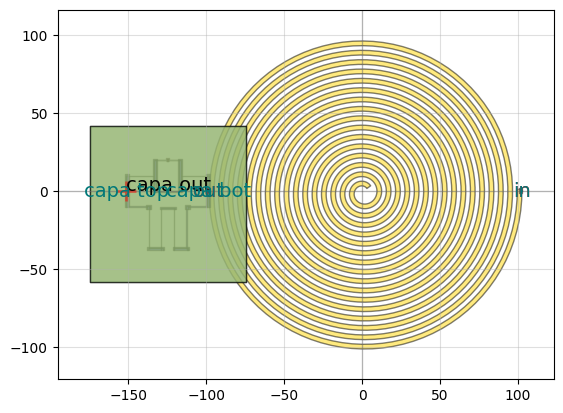

In [1192]:


small_squid_devices: list[QRCSJDevice] = []


small_squid_params = SquidParams(jj_width=0.12, bridge_width=0.4)

for i, (N, res_params, capa_params) in enumerate(zip(Ns_multiplex[:len(Ns_multiplex)//2-1], list_res_params, list_capa_params)):
    small_squid_device = QRCSJDevice()

    small_squid_device.assembled_device = Device('Small Squid Device')

    small_squid_devices.append(small_squid_device)

    squid_resistor = SquidResistor()

    capa_params.ebeam_capa_width=0
    squid_resistor.generate_squid_resistor(res_params, small_squid_params, capa_params, writefield_params)
    if not i%2:
        squid_resistor.device.mirror()
    

    spiral = Spiral()
    spiral.generate_spiral(SpiralParams(N=N, connector_shift=pg.extract(squid_resistor.device, layers=[default_ls['ebeam']]).ysize/2))
    
    small_squid_device.spiral = spiral
    spiral_ref = small_squid_device.assembled_device << spiral.device
    small_squid_device.assembled_device.add_port(spiral_ref.ports['in'])
    small_squid_device.assembled_device.add_port(spiral_ref.ports['out'])

    connect_to_resonator(squid_resistor, 'capa bot', spiral, 'capa right')
    small_squid_device.assembled_device.add_port(name='capa out', port=squid_resistor.device.ports['capa top'])


    if capa_params.no_resistor:
        squid_resistor.device.remove(squid_resistor.shunt_resistor)

    small_squid_device.assembled_device << squid_resistor.device
    
    small_squid_device.qubit = squid_resistor




squid_devices: list[QRCSJDevice] = []


squid_params = SquidParams()

for i, (N, res_params, capa_params) in enumerate(zip(Ns_multiplex[len(Ns_multiplex)//2-1:-2], list_res_params, list_capa_params)):
    squid_device = QRCSJDevice()


    squid_device.assembled_device = Device('Squid Device')   
    

    squid_devices.append(squid_device)

    squid_resistor = SquidResistor()
    capa_params.ebeam_capa_width=20
    squid_resistor.generate_squid_resistor(res_params, squid_params, capa_params, writefield_params)
    
    if i%2:
        squid_resistor.device.mirror()

    


    if i==4:
        spiral = Spiral()
        spiral.generate_spiral(SpiralParams(N=N, connector_shift=- pg.extract(squid_resistor.device, layers=[default_ls['ebeam']]).ysize/2))
        
        squid_device.spiral = spiral
        spiral_ref = squid_device.assembled_device << spiral.device
        squid_device.assembled_device.add_port(spiral_ref.ports['in'])
        squid_device.assembled_device.add_port(spiral_ref.ports['out'])

        connect_to_resonator(squid_resistor, 'capa top', spiral, 'capa left')
        squid_device.assembled_device.add_port(name='capa out', port=squid_resistor.device.ports['capa bot'])
        
    else:
        spiral = Spiral()
        spiral.generate_spiral(SpiralParams(N=N, connector_shift=pg.extract(squid_resistor.device, layers=[default_ls['ebeam']]).ysize/2))
        
        squid_device.spiral = spiral
        spiral_ref = squid_device.assembled_device << spiral.device
        squid_device.assembled_device.add_port(spiral_ref.ports['in'])
        squid_device.assembled_device.add_port(spiral_ref.ports['out'])

        connect_to_resonator(squid_resistor, 'capa bot', spiral, 'capa right')
        squid_device.assembled_device.add_port(name='capa out', port=squid_resistor.device.ports['capa top'])

    if capa_params.no_resistor:
        squid_resistor.device.remove(squid_resistor.shunt_resistor)

    squid_device.assembled_device << squid_resistor.device
    
    squid_device.qubit = squid_resistor




res_params = ResParams(num_segments=4, segment_length=25, spacing=8) #200kOhm

small_squid_device = QRCSJDevice()

small_squid_device.assembled_device = Device('Small Squid Device')

squid_devices.append(small_squid_device)

squid_resistor = SquidResistor()
capa_params.ebeam_capa_width=0
capa_params.length_y = capa_params.length_y + 7.775
squid_resistor.generate_squid_resistor(res_params, small_squid_params, capa_params, writefield_params)

squid_resistor.device.mirror()
squid_resistor.device.mirror(p1=(1,0), p2=(0,0))


spiral = Spiral()
spiral.generate_spiral(SpiralParams(N=Ns_multiplex[-2], connector_shift=pg.extract(squid_resistor.device, layers=[default_ls['ebeam']]).ysize/2))


small_squid_device.spiral = spiral
spiral_ref = small_squid_device.assembled_device << spiral.device
small_squid_device.assembled_device.add_port(spiral_ref.ports['in'])
small_squid_device.assembled_device.add_port(spiral_ref.ports['out'])

connect_to_resonator(squid_resistor, 'capa top', spiral, 'capa right')
small_squid_device.assembled_device.add_port(name='capa out', port=squid_resistor.device.ports['capa bot'])


if capa_params.no_resistor:
    squid_resistor.device.remove(squid_resistor.shunt_resistor)

small_squid_device.assembled_device << squid_resistor.device

small_squid_device.qubit = squid_resistor

 







spiral_devices: list[QRCSJDevice] = []

for N in [Ns_multiplex[-1]]:

    squid_device = QRCSJDevice()


    squid_device.assembled_device = Device('Squid Device')   
    

    spiral_devices.append(squid_device)

    squid_resistor = SquidResistor()
    squid_resistor.generate_squid_resistor(res_params, squid_params, capa_params, writefield_params)

    
    
    
    spiral = Spiral()
    spiral.generate_spiral(SpiralParams(N=N, connector_length=0))
    
    squid_device.spiral = spiral
    spiral_ref = squid_device.assembled_device << spiral.device
    squid_device.assembled_device.add_port(spiral_ref.ports['in'])
    squid_device.assembled_device.add_port(spiral_ref.ports['out'])


    connect_to_resonator(squid_resistor, 'capa bot', spiral, 'out')
    squid_resistor.device.movex(-squid_resistor.device.ports['capa bot'].width/2)
    
    # squid_resistor.device.move(origin=squid_resistor.device.ports['capa top'], destination=spiral_ref.ports['out'])

    # connect_to_resonator(squid_resistor, 'capa bot', spiral, 'capa right')
    squid_device.assembled_device.add_port(name='capa out', port=squid_resistor.device.ports['capa top'])

    squid_device.assembled_device << squid_resistor.device
    
    squid_device.qubit = squid_resistor


    # spiral_device = QRCSJDevice()
    # spiral_device.assembled_device = Device('Spiral Device')

    # spiral = Spiral()
    # spiral.generate_spiral(SpiralParams(N=N, connector_length=0))
    
    # spiral_device.spiral = spiral
    # spiral_ref = spiral_device.assembled_device << spiral.device
    # spiral_device.assembled_device.add_port(spiral_ref.ports['in'])
    # spiral_device.assembled_device.add_port(spiral_ref.ports['out'])

    # spiral_devices.append(spiral_device)

    

all_devices =  small_squid_devices + squid_devices + spiral_devices

qp(spiral_devices[0].assembled_device)

In [1193]:
all_devices

[QRCSJDevice(assembled_device=Device (name "Small Squid Device" (uid 134263), ports ['in', 'out', 'capa out'], aliases [], 0 polygons, 2 references), spiral=<components.spiral.Spiral object at 0x000001F37434A7D0>, qubit=<components.squid_resistor.SquidResistor object at 0x000001F3747F7430>, position=None, number=None, id=None),
 QRCSJDevice(assembled_device=Device (name "Small Squid Device" (uid 134389), ports ['in', 'out', 'capa out'], aliases [], 0 polygons, 2 references), spiral=<components.spiral.Spiral object at 0x000001F3747D4880>, qubit=<components.squid_resistor.SquidResistor object at 0x000001F37434A470>, position=None, number=None, id=None),
 QRCSJDevice(assembled_device=Device (name "Small Squid Device" (uid 134601), ports ['in', 'out', 'capa out'], aliases [], 0 polygons, 2 references), spiral=<components.spiral.Spiral object at 0x000001F374885630>, qubit=<components.squid_resistor.SquidResistor object at 0x000001F3747E9750>, position=None, number=None, id=None),
 QRCSJDevi

In [1194]:
def add_ground_capacitor(reference: DeviceReference,
                         port_name: str,
                         feedline: Feedline,
                         length: float = 500,
                         width: float = 3,
                         capa_distance: float = capa_spacing + shadow_shift,
                         layer: Layer = default_ls['routing']) -> None:
    
    element_port: Port = reference.ports[port_name]
    element_normal = element_port.normal[1] - element_port.normal[0]

    ground_capacitor = Device('Ground capacitor')
    ground_capacitor << pg.rectangle(size=(width, length), layer=layer)

    if length > 0:
        ground_capacitor.add_port(name='capa in', 
                              midpoint=(0, length - element_port.width/2),
                              width=element_port.width,
                              orientation=180)
    else:
         ground_capacitor.add_port(name='capa in', 
                              midpoint=(0, length + element_port.width/2),
                              width=element_port.width,
                              orientation=180)
    
    
    ground_capacitor_ref = feedline.device << ground_capacitor
    ground_capacitor_ref.connect('capa in', element_port)
    ground_capacitor_ref.move(element_normal * capa_distance)

    



# def add_ground_capacitor(element: DeviceReference,
#                          element_port_name: str, 
#                          feedline: Feedline,
#                          device_number: int, 
#                          capa_length: float,
#                          capa_distance: float = capa_spacing + shadow_shift,
#                          width = 3,
#                          overlap = 20) -> None:

#     element_port: Port = element.ports[element_port_name]

#     distance_to_ground = np.abs(- element.ports['out'].y + feedline.device.ports[f'device {device_number} ground'].y)

#     ground_capa = feedline.device << pg.compass(size=(width, distance_to_ground + overlap + capa_length), layer=default_ls['routing'])

#     ground_capa.connect(ground_capa['W'], element_port)

#     # ground_normal = feedline.device.ports[f'device {device_number} ground'].normal[1] - feedline.device.ports[f'device {device_number} ground'].normal[0]
#     # capa_normal = ground_capa.pad.ports['ground'].normal[1] - ground_capa.pad.ports['ground'].normal[0]
    
#     # angle = np.round((360/(2*np.pi)) * np.arccos(np.clip(np.dot(ground_normal, capa_normal), -1, 1)))%360

#     # if angle != 0:
#     #     ground_capa.device.rotate(angle)

#     # ground_capa.device.move(ground_capa.plate.ports['capa'], element_port)
#     # ground_capa.device.move(-capa_distance * ground_normal)

#     # feedline.device << ground_capa.device

In [1195]:
# feedline_bot.device.write_gds('Feedline_Bot.gds')

# with open('feedline_bot.pkl', 'wb') as f:
#     pickle.dump(feedline_bot, f)

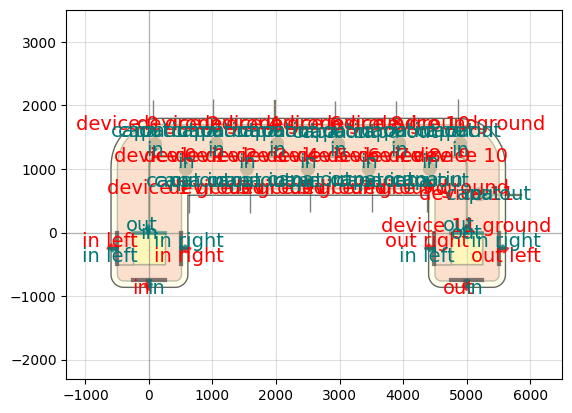

In [1196]:
coupling_distance = 100
all_device_refs: list[DeviceReference] = []

shift = 4.3


for i,device in enumerate(all_devices):
    all_device_refs.append(feedline_bot.device << device.assembled_device)

    all_device_refs[-1].connect('in', feedline_bot.device.ports[f'device {i}'])

    normal = all_device_refs[-1].ports['in'].normal[0] - all_device_refs[-1].ports['in'].normal[1]
    all_device_refs[-1].move(normal * coupling_distance)

    if i<len(all_devices)-1:
        if i == len(all_devices) - 3:
            add_ground_capacitor(all_device_refs[-1], 'capa out', feedline_bot, length=-500)
            device.qubit.device.movey(-shift)
        else:
            add_ground_capacitor(all_device_refs[-1], 'capa out', feedline_bot)
            device.qubit.device.movey(shift)

    else:
        ground_capa = GroundCapa()
        ground_capa.generate_ground_capa(GroundCapaParams(distance_to_ground=500, orientation=0, capa_width=10))

        device.qubit.device.movex(-capa_spacing-shadow_shift)

        ground_capa_ref = device.assembled_device << ground_capa.device
        ground_capa_ref.rotate(90)
        ground_capa_ref.move(origin=(ground_capa_ref.xmax+capa_spacing+shadow_shift, (ground_capa_ref.ymax + ground_capa_ref.ymin)/2), destination=device.qubit.device.ports['capa top'])


    device.number = i
    device.id = f'Bot {i}'
    device.position = all_device_refs[-1].center

qp(feedline_bot.device)

In [1197]:
# Extra spiral

# spiral_device = QRCSJDevice()
# spiral_device.assembled_device = Device('Spiral Device')

# spiral = Spiral()
# spiral.generate_spiral(SpiralParams(N=stop_N + 3*small_N_spacing, connector_length=0))

# spiral_device.spiral = spiral
# spiral_ref = spiral_device.assembled_device << spiral.device
# spiral_device.assembled_device.add_port(spiral_ref.ports['in'])
# spiral_device.assembled_device.add_port(spiral_ref.ports['out'])

# spiral_devices.append(spiral_device)
# all_devices.append(spiral_device)

# all_device_refs.append(feedline_bot.device << spiral_device.assembled_device)

# i=len(device_points) -1
# all_device_refs[-1].connect('in', feedline_bot.device.ports[f'device {i}'])

# normal = all_device_refs[-1].ports['in'].normal[0] - all_device_refs[-1].ports['in'].normal[1]
# all_device_refs[-1].move(normal * coupling_distance)

# device.number = i
# device.id = f'Bot {i}'
# device.position = all_device_refs[-1].center

In [1198]:
for dev in all_devices:
    print(dev.spiral.spiral_params.N)
    print(dev.spiral.get_resonance_frequency())

15.1
9158233433.994877
15.32
8878007279.311695
15.54
8609000824.664276
15.16
9080660084.386648
15.38
8803554781.896894
15.6
8537503992.74585
15.21
9016679365.868717
15.43
8742139467.395813
15.65
8478518743.316563
15.26
8953294061.07327
15.48
8681287996.715015
15.9
8191480325.442791


In [1199]:
feedline_bot.correct_optical_layer()

In [1200]:
feedline_bot.device.mirror(p1=(-1, 0), p2=(1,0))
#feedline_bot.device.mirror()

feedline_bot.device.write_gds('Feedline_Top.gds')

with open('feedline_top.pkl', 'wb') as f:
    pickle.dump(feedline_bot, f)